# Fundamental Concepts:
1. Compact Binary Coalescence (CBC): 

   When two black holes orbit each other, they lose energy by emitting gravitational waves. As they lose energy, they spiral inward, orbiting faster and faster until they smash into each other.
   
2. The "Chirp" Signal
   * Inspiral: The waves start at a low frequency and low amplitude.
   * Merger: As the holes get closer, the frequency pitch sweeps up rapidly (the "whoop" sound) and the amplitude spikes.
   * Ringdown: The final single black hole settles down, and the signal dies out.
     
3. The Challenge: The Noise Floor

   Gravitational waves are unimaginably weak. The strain on the detector is about $10^{-21}$. That is smaller than the width of a proton.The signal is usually buried deep inside the noise. You cannot see it with your eyes.

4. 1D Convolutional Neural Networks (1D-CNN)

   We used 2D CNNs for images. For this "audio-like" data, we will use a 1D CNN.
   * It slides a filter across the time-series (just like the 2D filter slid across the image).
   * It is incredibly good at picking out specific shapes (like the Chirp) even when they are hidden in static.

In [1]:
# Physical Model

# 0. Import Libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. Establish the Physics Model
def generate_chirp_signal(duration=1.0, sample_rate=4096):
    """
    Generates a synthetic Gravitational Wave "Chirp" (Inspiral phase).
    Approximation based on Newtonian Quadrupole formula.
    """
    dt = 1.0 / sample_rate
    t = np.linspace(0, duration, int(duration * sample_rate))
    
    # Merger time (set to be near the end of the clip)
    t_c = duration + 0.05 
    
    # Avoid division by zero by stopping slightly before singularity
    time_to_merger = t_c - t
    time_to_merger[time_to_merger < 0.01] = 0.01
    
    # 1. Frequency Evolution (sweeps up)
    # f ~ (time_to_merger)^(-3/8)
    phase = -20 * (time_to_merger ** (5/8)) # Integrated frequency
    
    # 2. Amplitude Evolution (gets louder)
    # A ~ (time_to_merger)^(-1/4)
    amplitude = time_to_merger ** (-1.0/4.0)
    amplitude = amplitude / np.max(amplitude) # Normalize to 0-1
    
    # The Waveform
    signal = amplitude * np.sin(2 * np.pi * phase * 10) # *10 scales it to audible freq
    
    # Envelope (taper the start so it doesn't click)
    envelope = np.ones_like(signal)
    envelope[:100] = np.linspace(0, 1, 100)
    signal = signal * envelope
    
    return t, signal

In [3]:
# 2. Add the Noise

def add_noise(signal, snr=0.5):
    """
    Adds Gaussian white noise. 
    SNR < 1 means the noise is LOUDER than the signal.
    """
    noise = np.random.normal(0, 1.0, signal.shape)
    
    # Scale signal to match desired SNR
    # SNR = RMS(signal) / RMS(noise)
    signal_rms = np.sqrt(np.mean(signal**2))
    noise_rms = np.sqrt(np.mean(noise**2))
    
    scale_factor = (noise_rms * snr) / signal_rms
    scaled_signal = signal * scale_factor
    
    return scaled_signal + noise, scaled_signal

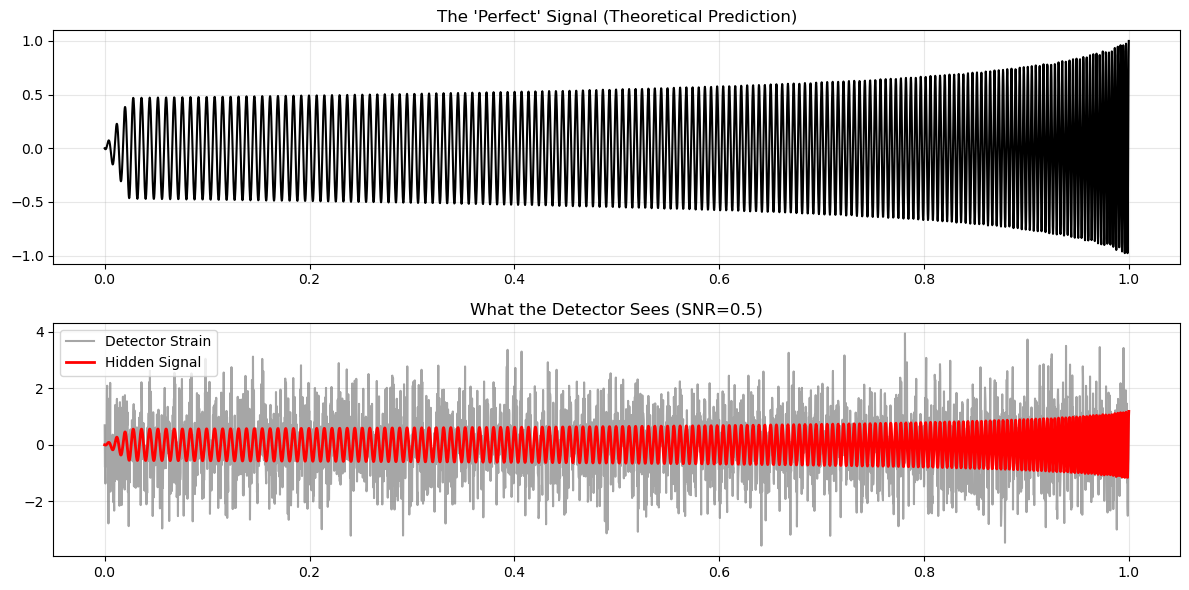

In [4]:
# 3. Visualize

t, pure_chirp = generate_chirp_signal()
noisy_data, scaled_signal = add_noise(pure_chirp, snr=0.5)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("The 'Perfect' Signal (Theoretical Prediction)")
plt.plot(t, pure_chirp, color='black')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title(f"What the Detector Sees (SNR=0.5)")
plt.plot(t, noisy_data, color='gray', alpha=0.7, label='Detector Strain')
plt.plot(t, scaled_signal, color='red', linewidth=2, label='Hidden Signal')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# 4. Adding 1D CNN.
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def generate_chirp_signal(duration=1.0, sample_rate=2048): # Lower sample rate for speed
    dt = 1.0 / sample_rate
    t = np.linspace(0, duration, int(duration * sample_rate))
    t_c = duration + 0.05 
    time_to_merger = t_c - t
    time_to_merger[time_to_merger < 0.01] = 0.01
    
    # Physics: Frequency and Amplitude evolution
    phase = -20 * (time_to_merger ** (5/8))
    amplitude = time_to_merger ** (-1.0/4.0)
    amplitude = amplitude / np.max(amplitude)
    
    signal = amplitude * np.sin(2 * np.pi * phase * 10)
    envelope = np.ones_like(signal)
    envelope[:100] = np.linspace(0, 1, 100)
    
    return signal * envelope

def generate_gw_dataset(n_samples=2000, sample_rate=2048):
    print(f"Generating {n_samples} samples of Gravitational Wave data...")
    
    X = []
    y = []
    
    for _ in range(n_samples):
        # 1. Create Pure Noise Background
        noise = np.random.normal(0, 1.0, sample_rate)
        
        # 2. Decide: Is there a Black Hole? (50/50 chance)
        has_signal = np.random.choice([0, 1])
        
        if has_signal:
            # Generate the Chirp
            chirp = generate_chirp_signal(duration=1.0, sample_rate=sample_rate)
            
            # Randomize SNR (Signal Strength)
            # SNR between 0.5 (Very Hard) and 2.0 (Easy)
            snr = np.random.uniform(0.5, 2.0)
            
            chirp_rms = np.sqrt(np.mean(chirp**2))
            noise_rms = np.sqrt(np.mean(noise**2))
            scale = (noise_rms * snr) / chirp_rms
            
            # Inject Signal
            data = noise + (chirp * scale)
            y.append(1)
        else:
            # Just Noise
            data = noise
            y.append(0)
            
        X.append(data)
        
    return np.array(X), np.array(y)

In [6]:
# Generate Data
X_raw, y = generate_gw_dataset(n_samples=4000)

# Reshape for CNN: (Samples, TimeSteps, Channels)
# We have 2048 time steps and 1 channel (Strain)
X = X_raw.reshape(-1, 2048, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Shape: {X_train.shape}")

Generating 4000 samples of Gravitational Wave data...
Data Shape: (3200, 2048, 1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, GlobalAveragePooling1D, Dropout

# Build the 1D Convolutional Network
model = Sequential([
    # Layer 1: Feature Extraction
    # 16 filters looking for patterns. 
    # Kernel size 32 means each filter looks at ~0.015s of data at a time.
    Conv1D(filters=16, kernel_size=32, activation='relu', input_shape=(2048, 1)),
    MaxPooling1D(pool_size=4), # Shrink data by 4x
    
    # Layer 2: Deeper Features
    Conv1D(filters=32, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=4),
    
    # Layer 3: High-Level Abstraction
    Conv1D(filters=64, kernel_size=8, activation='relu'),
    
    # Global Pooling: "Summarize" the whole timeline
    GlobalAveragePooling1D(),
    
    # Decision Head
    Dropout(0.2), # Prevent memorization
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # 0 = Noise, 1 = Black Hole Merger
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 2017, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 504, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 489, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 122, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 115, 64)             │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,313 (106.69 KB)

 Trainable params: 27,313 (106.69 KB)

 Non-trainable params: 0 (0.00 B)

Training GW Detector...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.7328 - loss: 0.4158 - val_accuracy: 1.0000 - val_loss: 9.5632e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 2.7888e-04
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 7.9296e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.8248e-04 - val_accuracy: 1.0000 - val_loss: 7.0006e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 1.4959e-04 - val_accuracy: 1.0000 - val_loss: 7.0233e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 1.0205e-04 - val_accuracy: 1.0000 - val_loss: 3.8103e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 7.8654e-05 - val_accuracy: 1.0000 - val_loss: 4.3923e-04
Epoch 8/10
100/100 ━━━━━━━━━

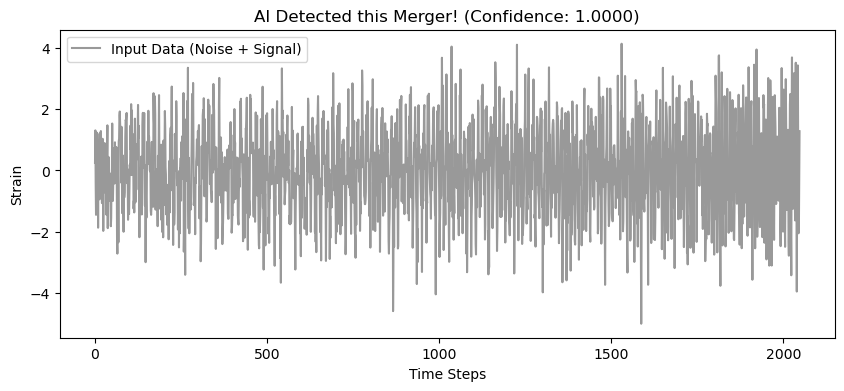

In [11]:
# Train and Evaluate

# Train
print("Training GW Detector...")
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=1)

# Evaluate Performance 
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Visual Proof 
# Let's find a "Hidden" signal the AI caught
preds = model.predict(X_test)
found_indices = np.where((preds > 0.9) & (y_test == 1))[0]

if len(found_indices) > 0:
    idx = found_indices[0] # Pick the first successful detection
    
    plt.figure(figsize=(10, 4))
    plt.plot(X_test[idx], color='gray', alpha=0.8, label='Input Data (Noise + Signal)')
    plt.title(f"AI Detected this Merger! (Confidence: {preds[idx][0]:.4f})")
    plt.xlabel("Time Steps")
    plt.ylabel("Strain")
    plt.legend()
    plt.show()